In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.conformal import (
    NonconformityScores,
    PostHocProbabilisticMethod,
    PostHocProbabilisticProcessor,
)
from tsfm_public.toolkit.time_series_anomaly_detection_pipeline import TimeSeriesAnomalyDetectionPipeline
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

/dccstor/kiruna/conda_envs/tsfm_conformal/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `PYTORCH_PRETRAINED_BERT_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/dccstor/kiruna/conda_envs/tsfm_conformal/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `PYTORCH_TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/dccstor/kiruna/conda_envs/tsfm_conformal/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


# Example Datafile

Data instance from IOPS dataset ([Paper](https://arxiv.org/html/2402.10802v1)). The data example is a part of the IOPS dataset.

The IOPS data set is an anonymized dataset with performance indicators that reflect the scale, quality of web services, and health status of a machine.



In [2]:
data_path = "https://huggingface.co/datasets/AutonLab/Timeseries-PILE/resolve/main/anomaly_detection/TSB-UAD-Public/IOPS/KPI-4d2af31a-9916-3d9f-8a8e-8a268a48c095.test.out"


## Helper Functions for Data Loading and Processing

`load_data` loads the large dataset in chunks.

`attach_timestamp_column` current pipeline expects a timestamp column in the input. The IOPS dataset does not have an explicit time column specified. This helper function attach a dummy timestamp column to the dataset.



In [3]:
def load_data(file_path: str, max_length: int, min_length: int):
    data = []
    extra_args = {}
    if file_path.endswith("gz"):
        extra_args["compression"] = "gzip"
    for chunk in pd.read_csv(file_path, header=None, sep=",", chunksize=max_length, *extra_args):
        if (chunk is None) or (chunk.ndim != 2):
            break
        chunk.columns = ["x", "y"]
        chunk["x"] = chunk.x.interpolate(method="cubic").ffill().bfill()
        chunk["y"] = chunk.y.ffill().bfill()
        if chunk.shape[0] > min_length:
            data.append(chunk)
        elif len(data) > 0:
            data[-1] = pd.concat([data[-1], chunk], axis=0)
    return data


def attach_timestamp_column(
    df: pd.DataFrame, time_col: str = "timestamp", freq: str = "D", start_date: str = "2022-01-01"
):
    n = df.shape[0]
    if time_col not in df:
        df[time_col] = pd.date_range(start_date, freq=freq, periods=n)
    return df

In [4]:
max_length, min_length = 5_000, 2_000
data = load_data(data_path, max_length, min_length)

In [5]:
validation_df = attach_timestamp_column(data[10], time_col="timestamp", freq="s")
validation_df.head()

,x,y,timestamp
50000,5.00,0,2022-01-01 00:00:00
50001,4.80,0,2022-01-01 00:00:01
50002,5.25,0,2022-01-01 00:00:02
50003,4.95,0,2022-01-01 00:00:03
50004,5.05,0,2022-01-01 00:00:04


## Parameters

In [6]:
############# Parameters #############
np.random.seed(42)

"""
Dataset
"""
target_variables = ["x"]
timestamp_column = "timestamp"
frequency_token = "oov"

"""
TTM
"""
model_checkpoint = "ibm-granite/granite-timeseries-ttm-r2"
ttm_model_revision = "52-16-ft-l1-r2.1"
prediction_length = 15
context_length = 52

"""
Preprocessor
"""
alarm_rate = 0.01
quantiles = [alarm_rate / 2, 1 - alarm_rate / 2]
method = "probabilistic"
aggregation = "mean"

######################################

window_size_min = int(np.ceil(1 / alarm_rate)) + 10

## Initializing  Model, Probabilistic Processor and TS preprocessor

In [7]:
"""
TTM Forecaster Model Initialization
"""
model = TinyTimeMixerForPrediction.from_pretrained(
    model_checkpoint, revision=ttm_model_revision, prediction_filter_length=prediction_length
)
print(model)

"""
Initialize PostHoc Probabilistic Processor
"""

prob_proc = PostHocProbabilisticProcessor(
    window_size=window_size_min,
    quantiles=quantiles,
    nonconformity_score=NonconformityScores.ABSOLUTE_ERROR.value,
    method=PostHocProbabilisticMethod.CONFORMAL.value,
    smoothing_length=None,
    aggregation=aggregation,
)

"""
Time Series Preprocessor Initialization
"""
tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_variables,
    context_length=context_length,
    prediction_length=prediction_length,
    freq="d",  ## needs a dummy value
    scaling=False,
)
data = tsp._standardize_dataframe(validation_df)

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=4, out_features=20, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0-11): 12 x TinyTimeMixerLayer(
            (patch_mixer): PatchMixerBlock(
              (norm): TinyTimeMixerNormLayer(
                (norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
              )
              (mlp): TinyTimeMixerMLP(
                (fc1): Linear(in_features=14, out_features=42, bias=True)
                (dropout1): Dropout(p=0.3, inplace=False)
                (fc2): Linear(in_features=42, out_features=14, bias=True)
                (dropout2): Dropout(p=0.3, inplace=False)
              )
              (gating_block): TinyTimeMixerGatedAttention(
                (attn_layer): Linear(in_features=14, out_features=14, bias=True)
                (attn_softmax): Softmax(dim=-1)
              )
        

### Calibration of PostHoc Probabilistic Processor

In [8]:
"""
Calibration + Training of PostHoc Probabilistic Processor
"""
## Calibration Data
data_cal = data.iloc[: context_length + prediction_length + window_size_min]

## Preprocessor calibration
tsp.train(data_cal)

## Timeseries forecast pipeline to forecast calibration points
fpipe = TimeSeriesForecastingPipeline(model, feature_extractor=tsp, device="cpu")
# forecasts = fpipe(data_cal, freq="oov")
forecasts_cal = fpipe(data_cal)

## Calibration predictions to probabilistic processor input shapes (y_cal_gt, y_cal_pred of shape N,H,F)
prediction_columns = [f"{c}_prediction" for c in target_variables]

#### Train Prob processor ####
prob_proc.train(
    y_cal_gt=forecasts_cal[tsp.target_columns].iloc[:-prediction_length],
    y_cal_pred=forecasts_cal[prediction_columns].iloc[:-prediction_length],
)

Device set to use cpu


PostHocProbabilisticProcessor {
  "aggregation": "mean",
  "aggregation_axis": 1,
  "critical_size": 100.0,
  "false_alarm": 0.01,
  "feature_extractor_type": "PostHocProbabilisticProcessor",
  "method": "conformal",
  "model": {
    "false_alarm": 0.01,
    "nonconformity_score": "absolute_error",
    "threshold_function": "weighting",
    "univariate_wrappers": {
      "[0, 0]": {
        "cal_X": [],
        "cal_scores": [
          0.7902970314025879,
          0.06747865676879883,
          0.0370330810546875,
          0.2317657470703125,
          0.022839069366455078,
          0.46599769592285156,
          0.12308788299560547,
          0.16448497772216797,
          0.26862382888793945,
          0.026929855346679688,
          0.26040172576904297,
          0.09191274642944336,
          0.04360342025756836,
          0.05426168441772461,
          0.17497730255126953,
          0.5895161628723145,
          0.046475887298583984,
          0.10675621032714844,
          0.

### Time Series Anomaly Detection Pipeline 

In [9]:
"""
Time Series Anomaly Detection Pipeline
"""

tspipe = TimeSeriesAnomalyDetectionPipeline(
    model,
    prediction_mode=method,
    probabilistic_processor=prob_proc,
    timestamp_column=timestamp_column,
    target_columns=target_variables,
    feature_extractor=tsp,
    device="cpu",
)

result = tspipe(data, expand_score=True)

Device set to use cpu


Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier score shape (128, 15, 1)
Outlier sc

### Plot Results

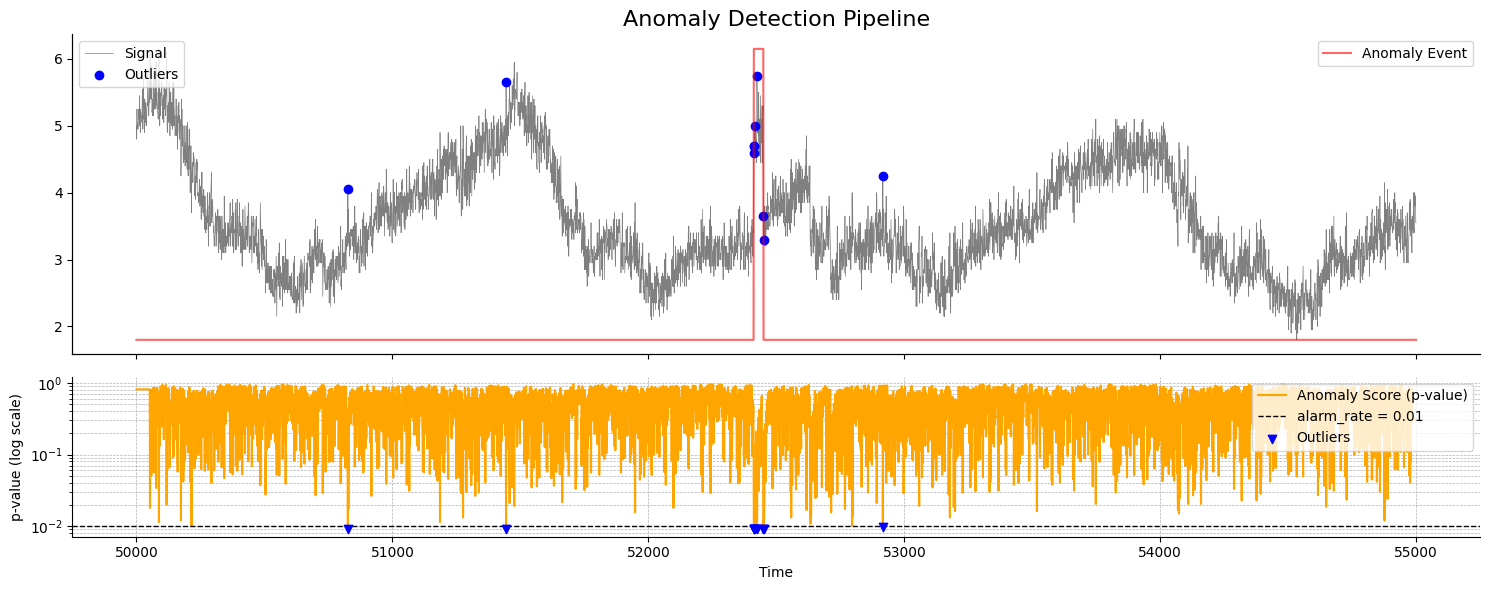

In [20]:
# Compute Outliers
result["detections"] = (result["anomaly_score"] <= alarm_rate).astype(float)

# Extract detection indices and values
detected_idx = result.index[result["detections"] == 1.0]
detected_vals_signal = result["x"][result["detections"] == 1.0]
detected_vals_pvalue = result["anomaly_score"][result["detections"] == 1.0]


####### Create plots ######
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

ax1b = ax1.twinx()

# Plot 1: Signal + Outliers + Anomaly Events
result.x.plot(ax=ax1, color="gray", linewidth=0.5, label="Signal")
ax1.scatter(detected_idx, detected_vals_signal, color="blue", marker="o", label="Outliers", zorder=5)
result.y.plot(ax=ax1b, color="red", linewidth=1.5, label="Anomaly Event", alpha=0.6)

ax1.set_title("Anomaly Detection Pipeline", fontsize=16)
ax1.legend(loc="upper left")
ax1b.legend(loc="upper right")
ax1b.set_yticks([])

for s in ["top", "right"]:
    ax1.spines[s].set_visible(False)
    ax1b.spines[s].set_visible(False)

# Plot 2: P-values + Ouliers
result.anomaly_score.plot(ax=ax2, color="orange", label="Anomaly Score (p-value)")
ax2.set_yscale("log")
ax2.set_ylabel("p-value (log scale)")
ax2.set_xlabel("Time")

ax2.axhline(y=alarm_rate, color="black", linestyle="--", linewidth=1, label=f"alarm_rate = {alarm_rate}")
ax2.scatter(detected_idx, detected_vals_pvalue, color="blue", marker="v", label="Outliers", zorder=5)

ax2.legend(loc="upper right")
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)

for s in ["top", "right"]:
    ax2.spines[s].set_visible(False)

plt.tight_layout()
plt.show()